In [1]:
import pandas as pd
import statsmodels as sm
import bokeh
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score
from pandas import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

<ipython-input-1-65b7492f41f5>:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


 Считать данные из training.xlsx. 

In [2]:
train = pd.read_excel('training.xlsx', parse_dates = ['Date'], index_col = 'Date')
test = pd.read_excel('testing.xlsx', parse_dates = ['Date'], index_col = 'Date')

In [3]:
train.head()

,Value
Date,
1959-01-01,22.8331
1959-02-01,23.2802
1959-03-01,23.6156
1959-04-01,24.1186
1959-05-01,24.4820


In [4]:
print ('Проверка на пропуски(train) :\n', train.isna().sum())
print ('Проверка на пропуски(test) :\n', test.isna().sum())

Проверка на пропуски(train) :
 Value    0
dtype: int64
Проверка на пропуски(test) :
 Value    0
dtype: int64


distplot одновременно показывает гистограмму и график плотности распределения.

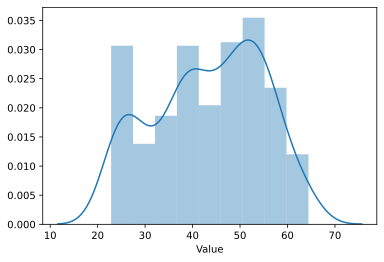

In [5]:
sns.distplot(train['Value']);

In [6]:
train.describe()

,Value
count,360.000000
mean,43.347284
std,11.445942
min,22.833100
25%,35.843875
50%,44.769500
75%,52.962875
max,64.421000


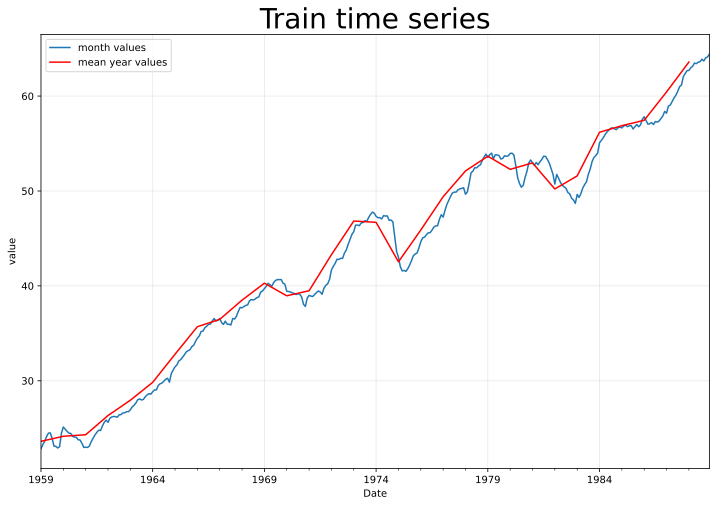

In [7]:
train_values = train.Value
train_values.plot(figsize = (12,8), label = 'month values')
train_values.resample("y").mean().plot(figsize = (12,8), color = 'r', label = 'mean year values')
plt.title("Train time series", fontsize=28)
plt.legend(loc='upper left')
plt.xlabel("Date")
plt.ylabel("value")
plt.grid(alpha=.3)

# Тест Дикки-Фуллера

Для проверки стационарности проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. 
Выдвинем **гипотезу H0**, что временной ряд имеет единичный корень, то есть он нестационарный и имеет некоторую временную структуру. Если удастся ее отклонить, то будет верна **гипотеза H1**, что временной ряд является стационарным и временной структуры не имеет.

In [8]:
from statsmodels.tsa.stattools import adfuller
def DF_test(v):
    test = adfuller(v)
    print ('adf: ', test[0]) 
    print ('p-value: ', test[1])
    print ('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('Есть единичные корни, ряд не стационарен')
        return False
    else:
        print ('Единичных корней нет, ряд стационарен')
        return True

In [9]:
DF_test(train_values)

adf:  -0.2533911799284627
p-value:  0.9318510422993466
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
Есть единичные корни, ряд не стационарен


False

Сравнивая статистику теста adf с критическими значениями, похоже, что нам не следует отвергать нулевую гипотезу о том, что временной ряд нестационарный и имеет зависящую от времени структуру.

Определим порядок интегрирования временного ряда

In [10]:
def order(values):
    k = 0
    stac = False
    while not stac:
        k = k + 1
        otgdiff = values.diff(periods=k).dropna()
        test = adfuller(otgdiff)
        print ('adf: ', test[0]) 
        print ('p-value: ', test[1])
        print ('Critical values: ', test[4])
        stac = not (test[0] > test[4]['5%'])
    print('Порядок интегрирования временного ряда =',k)
    if test[0] > test[4]['5%']: 
        print ('Есть единичные корни, ряд не стационарен')
    else:
        print ('Единичных корней нет, ряд стационарен')
    return k

In [11]:
order(train_values)

adf:  -7.367311495211982
p-value:  9.164149561098284e-11
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
Порядок интегрирования временного ряда = 1
Единичных корней нет, ряд стационарен


1

В коде выше функция *diff()* вычисляет разность исходного ряда с рядом с заданным смещением периода. Период смещения передается как параметр *period*. Т.к. в разности первое значение получится неопределенным, то нам надо избавиться от него для этого и используется метод *dropna()*. Выполняем сдвиг до тех пор пока k-ые разности не приблизятся к стационарному ряду.

## Разложение на тренд, сезональность, остаток в соответствии с аддитивной, мультипликативной моделями. 

# Аддитивная модель


* Для аддитивной модели(y(t) = Level + Trend + Seasonality + Noise)

Аддитивная модель является линейной, где изменения во времени последовательно вносятся в одну и ту же величину.

Линейный тренд - это прямая линия.

Линейная сезонность имеет одинаковую частоту (ширина циклов) и амплитуду (высота циклов).

In [12]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

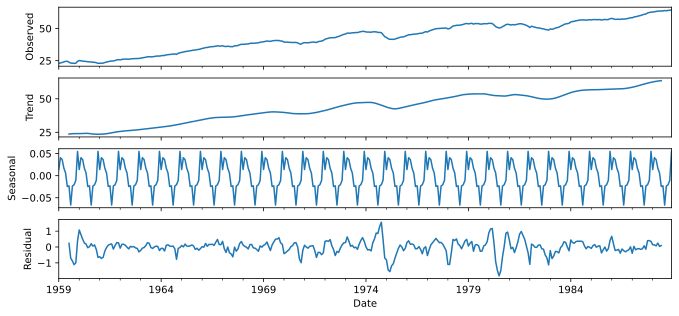

In [13]:
result = seasonal_decompose(train_values, model = 'additive')
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(411, ylabel='Observed')
result.observed.plot(ax=ax1)
ax2 = fig.add_subplot(412, ylabel='Trend', sharex=ax1)
result.trend.plot(ax=ax2)
ax3 = fig.add_subplot(413, ylabel='Seasonal', sharex=ax1)
result.seasonal.plot(ax=ax3)
ax4 = fig.add_subplot(414, ylabel='Residual', sharex=ax1)
result.resid.plot(ax=ax4)
plt.show()

In [14]:
# Проверка Тренда
result.trend.dropna(inplace=True)
DF_test(result.trend)

adf:  -0.8615760333583677
p-value:  0.800362576153234
Critical values:  {'1%': -3.4503224123605194, '5%': -2.870338478726661, '10%': -2.571457612488522}
Есть единичные корни, ряд не стационарен


False

In [15]:
# Проверка сезональности
result.seasonal.dropna(inplace=True)
DF_test(result.seasonal)

adf:  -204160621618461.8
p-value:  0.0
Critical values:  {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}
Единичных корней нет, ряд стационарен


True

In [16]:
# Проверка остаточного
result.resid.dropna(inplace=True)
DF_test(result.resid)

adf:  -7.485563833765426
p-value:  4.649096674694056e-11
Critical values:  {'1%': -3.4496162602188187, '5%': -2.870028369720798, '10%': -2.5712922615505627}
Единичных корней нет, ряд стационарен


True

# Мультипликативная модель

* Для мультипликативной модели(y(t) = Level * Trend * Seasonality * Noise)

Мультипликативная модель является нелинейной, такой как квадратичная или экспоненциальная. Изменения увеличиваются или уменьшаются со временем.

Нелинейный тренд - это изогнутая линия.

Нелинейная сезонность имеет возрастающую или уменьшающуюся частоту и / или амплитуду во времени.

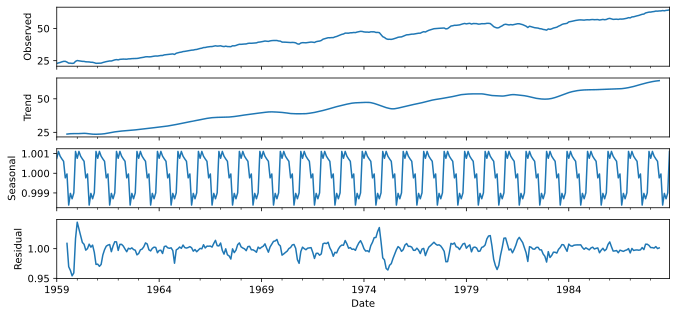

In [17]:
result1 = seasonal_decompose(train_values, model='multiplicative')
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(411, ylabel='Observed')
result1.observed.plot(ax=ax1)
ax2 = fig.add_subplot(412, ylabel='Trend', sharex=ax1)
result1.trend.plot(ax=ax2)
ax3 = fig.add_subplot(413, ylabel='Seasonal', sharex=ax1)
result1.seasonal.plot(ax=ax3)
ax4 = fig.add_subplot(414, ylabel='Residual', sharex=ax1)
result1.resid.plot(ax=ax4)
plt.show()

In [18]:
# Проверка Тренда
result1.trend.dropna(inplace=True)
DF_test(result1.trend)

adf:  -0.8615760333583677
p-value:  0.800362576153234
Critical values:  {'1%': -3.4503224123605194, '5%': -2.870338478726661, '10%': -2.571457612488522}
Есть единичные корни, ряд не стационарен


False

In [19]:
# Проверка сезональности
result1.seasonal.dropna(inplace=True)
DF_test(result1.seasonal)

adf:  -89091918565650.4
p-value:  0.0
Critical values:  {'1%': -3.4496162602188187, '5%': -2.870028369720798, '10%': -2.5712922615505627}
Единичных корней нет, ряд стационарен


True

In [20]:
# Проверка остаточного
result1.resid.dropna(inplace=True)
DF_test(result1.resid)

adf:  -7.466083739784919
p-value:  5.200193898334382e-11
Critical values:  {'1%': -3.4496162602188187, '5%': -2.870028369720798, '10%': -2.5712922615505627}
Единичных корней нет, ряд стационарен


True

In [21]:
order(train_values)

adf:  -7.367311495211982
p-value:  9.164149561098284e-11
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
Порядок интегрирования временного ряда = 1
Единичных корней нет, ряд стационарен


1

ARIMA зависит от параметров p, d, q

p = порядок AR (Авторегрессионная модель)
d = порядок дифференцирование
q = порядок MA (Модель скользящего среднего)

ACF (авторкорреляционная функция для ряда первых разностей) поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA.

PACF (частично автокорреляционная функция для ряда первых разностей) поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

### Графики автокорелляции 

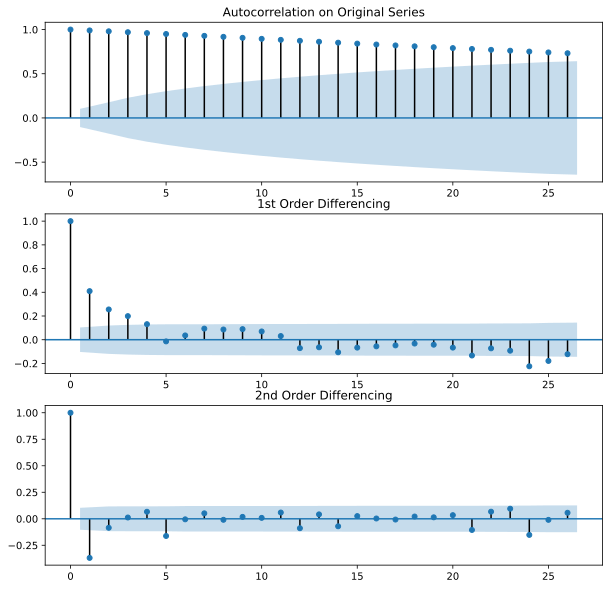

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(311)
fig = plot_acf(train_values.dropna(), ax=ax1,
               title="Autocorrelation on Original Series") 

ax2 = fig.add_subplot(312)
fig = plot_acf(train_values.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")

ax3 = fig.add_subplot(313)
fig = plot_acf(train_values.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

Посмотрим на график однократного дифференцирования => d=1. 
По коррелограмме ACF можно увидеть, что q = 4, т.к. после лага 4 значении функций резко падают.

### График частичной автокорелляции 

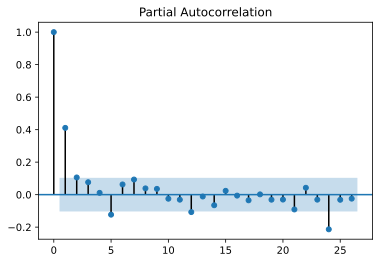

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_values.diff().dropna())
plt.show()

После изучения коррелограммы PACF можно сделать вывод, что p = 1, т.к. на ней только 1 лаг сильно отличнен от нуля. После изучения коррелограммы PACF можно сделать вывод, что p = 1, т.к. на ней только 1 лаг сильно отличнен от нуля. 

### Модель ARIMA
 

# 1

In [24]:
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

model = ARIMA(train_values, order=(8, 1, 3))
model_fit = model.fit(disp=0) 
print(model_fit.summary())

<ipython-input-24-d46bd66ca18f>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                 ARIMA(8, 1, 3)   Log Likelihood                -113.920
Method:                       css-mle   S.D. of innovations              0.331
Date:                Fri, 11 Dec 2020   AIC                            253.841
Time:                        22:10:13   BIC                            304.324
Sample:                    02-01-1959   HQIC                           273.916
                         - 12-01-1988                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1169      0.039      3.008      0.003       0.041       0.193
ar.L1.D.Value    -0.4930      0.217     -2.275      0.023      -0.918      -0.068
ar.L2.D.Value     0.1889      0.226     

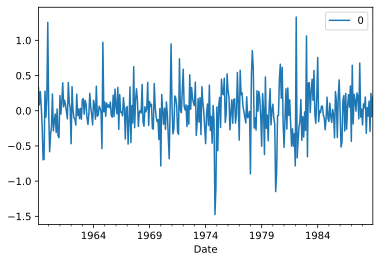

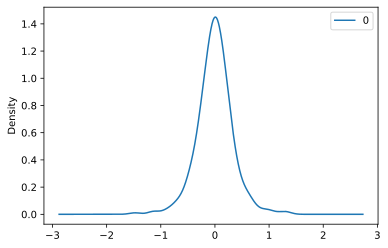

In [25]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()

In [26]:
print(residuals.describe())

                0
count  359.000000
mean    -0.000248
std      0.332687
min     -1.474969
25%     -0.177840
50%      0.003671
75%      0.178864
max      1.329480


Параметр mean = -0.000004 максимально близок к нулю при (p, d, q)=(6, 1, 2), что показывает, что данная модель предельно точна.

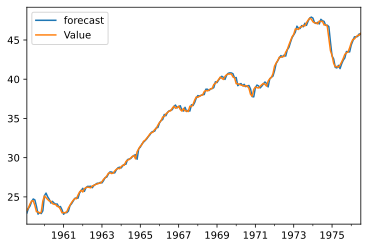

In [27]:
graph = model_fit.plot_predict(1, 210)
plt.show()

Точность предельно высокая!

### Вторая модель ARIMA

In [28]:
model2 = ARIMA(train_values, order=(1, 1, 3))
results2 = model2.fit()
print(results2.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -119.542
Method:                       css-mle   S.D. of innovations              0.337
Date:                Fri, 11 Dec 2020   AIC                            251.083
Time:                        22:10:14   BIC                            274.383
Sample:                    02-01-1959   HQIC                           260.349
                         - 12-01-1988                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1175      0.035      3.368      0.001       0.049       0.186
ar.L1.D.Value     0.4668      0.177      2.635      0.008       0.120       0.814
ma.L1.D.Value    -0.1175      0.173     

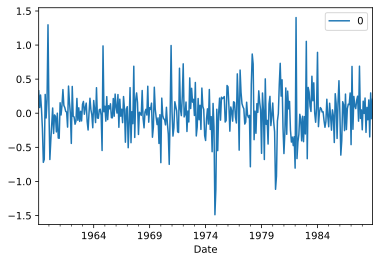

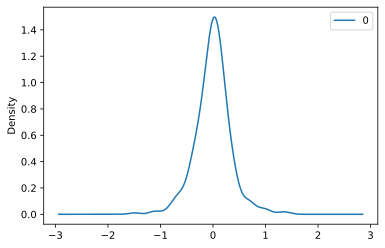

In [29]:
residuals = DataFrame(results2.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()

In [30]:
print(residuals.describe())

                0
count  359.000000
mean    -0.000580
std      0.338024
min     -1.488390
25%     -0.164406
50%      0.014374
75%      0.165880
max      1.403016


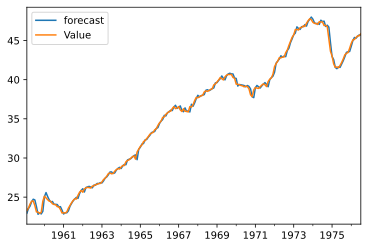

In [31]:
graph = results2.plot_predict(1, 210)
plt.show()

### 3 модель ARIMA

In [55]:
model3 = ARIMA(train_values, order=(12, 1, 4))
results3 = model3.fit()

print(results3.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                ARIMA(12, 1, 4)   Log Likelihood                -107.300
Method:                       css-mle   S.D. of innovations              0.325
Date:                Fri, 11 Dec 2020   AIC                            250.599
Time:                        22:25:01   BIC                            320.499
Sample:                    02-01-1959   HQIC                           278.396
                         - 12-01-1988                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1179      0.036      3.244      0.001       0.047       0.189
ar.L1.D.Value      0.3520      0.068      5.202      0.000       0.219       0.485
ar.L2.D.Value      0.8926      0.073

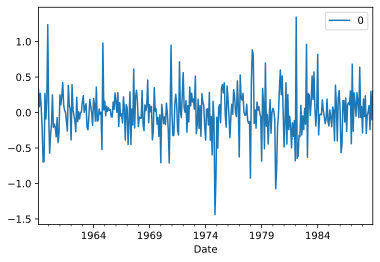

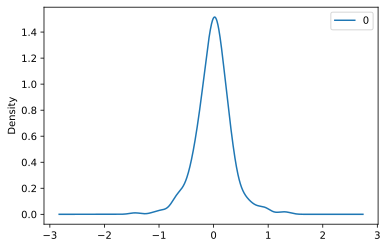

In [56]:
# plot residual errors
residuals3 = DataFrame(results3.resid)
residuals3.plot()
pyplot.show()
residuals3.plot(kind='kde')
pyplot.show()

In [57]:
print(residuals3.describe())

                0
count  359.000000
mean    -0.000534
std      0.326784
min     -1.437923
25%     -0.166488
50%      0.004694
75%      0.164032
max      1.344460


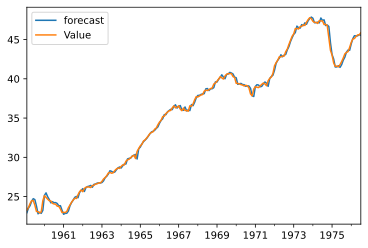

In [58]:
graph = results3.plot_predict(1, 210)
plt.show()

Информационный критерий Акаике (AIC) оценивает относительный объем информации, потерянной данной моделью. Чем меньше, тем лучше. => Модель ARIMA c параметрами (12,1,4) лучшая

1959-02-01    0.117905
1959-03-01    0.252013
1959-04-01    0.231863
1959-05-01    0.297616
1959-06-01    0.254401
Freq: MS, dtype: float64


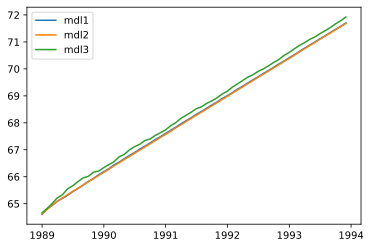

In [59]:
future_forecast_3 = results3.predict()
print(future_forecast_3.head())

pred1 = model_fit.predict(start='1989-01-01', end='1993-12-01', typ='levels')
pred2 = results2.predict(start='1989-01-01', end='1993-12-01', typ='levels')
pred3 = results3.predict(start='1989-01-01', end='1993-12-01', typ='levels')
plt.plot(pred1, label='mdl1')
plt.plot(pred2, label='mdl2')
plt.plot(pred3, label='mdl3')
plt.legend(loc='best')

In [60]:
print(test.tail())
print(pred1.tail())

              Value
Date               
1993-08-01  67.5985
1993-09-01  67.9241
1993-10-01  68.4390
1993-11-01  68.7289
1993-12-01  69.0884
1993-08-01    71.228964
1993-09-01    71.350298
1993-10-01    71.466919
1993-11-01    71.580088
1993-12-01    71.702632
Freq: MS, dtype: float64


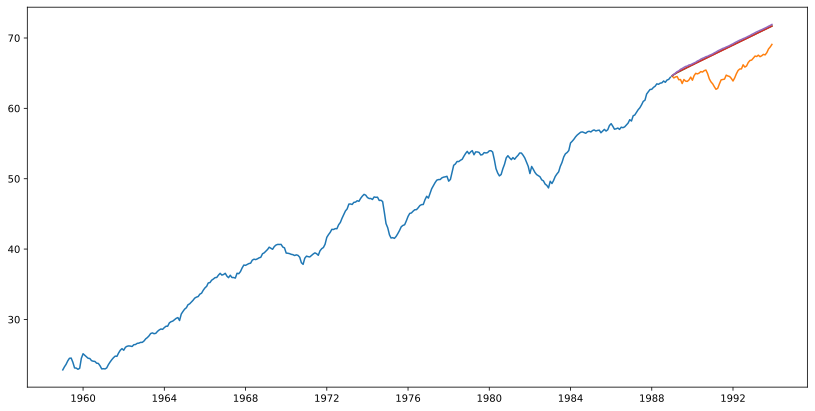

In [61]:
plt.figure(figsize=(14, 7))
plt.plot(train_values, label='Training')
plt.plot(test, label='Test')
plt.plot(pred1, label='mdl1')
plt.plot(pred2, label='mdl2')
plt.plot(pred3, label='mdl3')
plt.show()

# R2-score для наилучшей модели

In [62]:
print(r2_score(test, pred1))

-3.3787295706531975


По итогам критерия Акаике и наглядной интерпретации работы 3 моделей - была получена оптимальная - 3я. Параметры (p, d, q) =  12, 1, 4

С помощью этого задания были получены навыки и инструменты для работы с временными рядами.
Подобные задания имеют ярко выраженный прикладной характер. 